In [1]:
import re
import nltk
import spacy
import gensim
import random
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
from textblob import TextBlob
import matplotlib.pyplot as plt
import gensim.downloader as api
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from gensim.test.utils import datapath
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to C:\Users\SACS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\SACS/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\SACS/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\SACS/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SACS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Cargar el dataset
df = pd.read_csv("C:/Users/SACS/Downloads/Competencia/train.csv")
test = pd.read_csv("C:/Users/SACS/Downloads/Competencia/data_test.csv")
# Ver las primeras filas para inspeccionar la estructura
print(df.head())

                                                text                 book  \
0  Look at his legs!”\n“Confound you handsome you...          Middlemarch   
1  Meanwhile Mr. Pickwick had been wheeled to the...  The_Pickwick_Papers   
2  Rose had been in high spirits, too, and they h...         Oliver_Twist   
3  He\nheld his breath, and listened at the key-h...  The_Pickwick_Papers   
4  On hearing this most unexpected sound, Mr. Bum...         Oliver_Twist   

   label  
0      1  
1      0  
2      0  
3      0  
4      0  


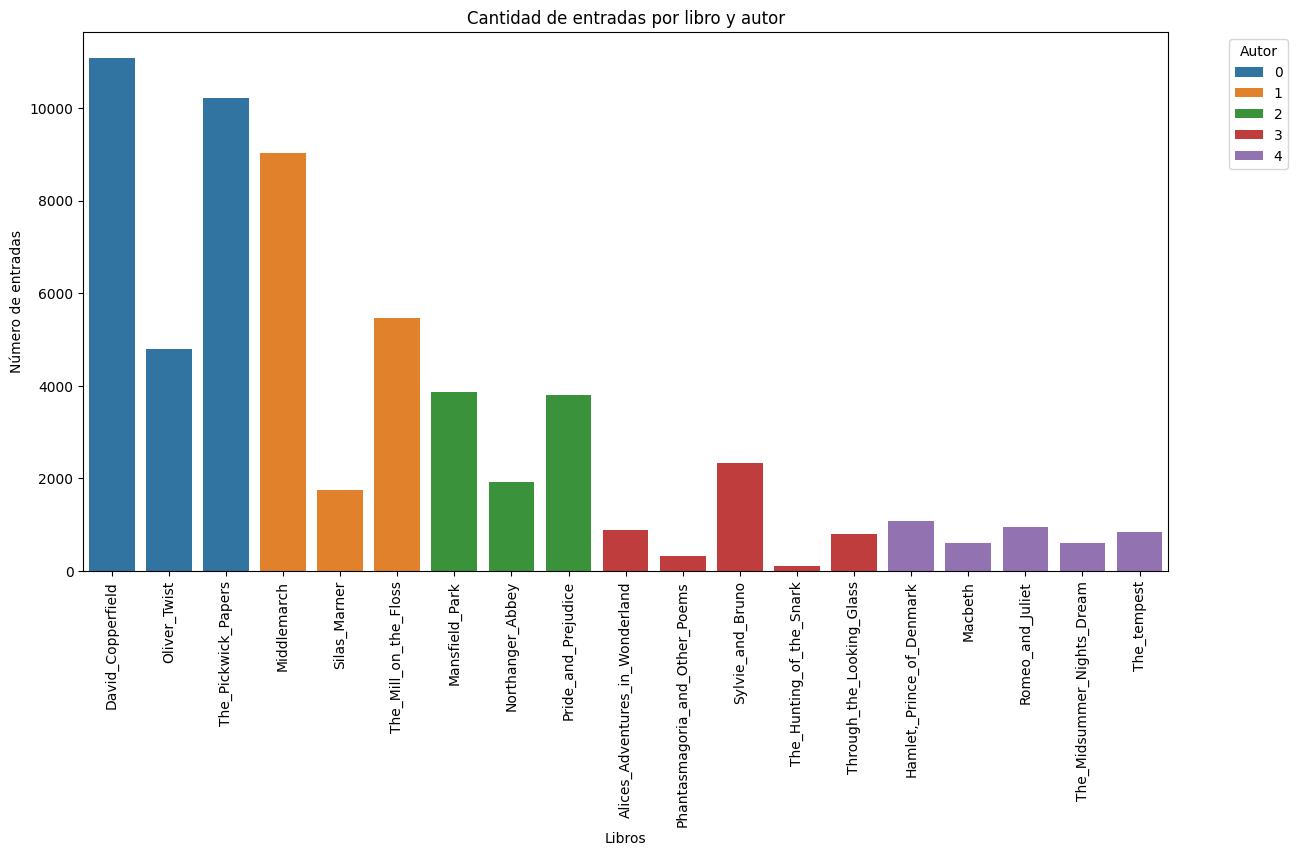

In [3]:
# Contar la cantidad de entradas por cada libro y su autor
conteo_libros_autores = df.groupby(['label', 'book']).size().reset_index(name='conteo')

# Crear la gráfica
plt.figure(figsize=(14, 7))
sns.barplot(x='book', y='conteo', hue='label', data=conteo_libros_autores, palette="tab10")

plt.xticks(rotation=90) 
plt.xlabel("Libros")
plt.ylabel("Número de entradas")
plt.title("Cantidad de entradas por libro y autor")
plt.legend(title="Autor", bbox_to_anchor=(1.05, 1), loc='upper left')  #
plt.show()


In [4]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
conteo_autores = y_train.value_counts()
minority_authors = conteo_autores[conteo_autores < 4500].index

# Función de fragmentación y recombinación
def fragmentar_y_recombinar(texto, num_fragments=3):
    """Divide un texto en fragmentos y los recombina aleatoriamente."""
    oraciones = texto.split(". ") 
    if len(oraciones) < num_fragments:
        return texto  
    random.shuffle(oraciones) 
    return ". ".join(oraciones[:num_fragments]) 

# Generar nuevas muestras
X_augmented = []
y_augmented = []

for autor in minority_authors:
    textos_autor = X_train[y_train == autor].tolist()
    
    for texto in textos_autor:
        nuevo_texto = fragmentar_y_recombinar(texto)
        X_augmented.append(nuevo_texto)
        y_augmented.append(autor)

X_augmented = pd.Series(X_augmented, index=[X_train.index.max() + i + 1 for i in range(len(X_augmented))])
y_augmented = pd.Series(y_augmented, index=X_augmented.index)

# Concatenar con los conjuntos de entrenamiento originales
X_train = pd.concat([X_train, X_augmented])
y_train = pd.concat([y_train, y_augmented])

# Verificar distribución final
print(y_train.value_counts())

0    20861
1    12991
2     7735
3     7112
4     6488
Name: count, dtype: int64


In [ ]:
pipeline = ImbPipeline([ 
        ('vectorizer', CountVectorizer()),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', MultinomialNB(alpha=0.1))     
    ])

param_grid = [
    {
        'vectorizer': [CountVectorizer(lowercase=False, strip_accents='ascii'), TfidfVectorizer(lowercase=False, strip_accents='ascii')],
        'sampler__sampling_strategy': ['minority', 'not majority'],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
    }
]

# GridSearch
print("GridSearch para Bolsa de palabras y TF-IDF")
grid = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Obtener mejores parámetros
print("- Mejores parámetros:", grid.best_params_)
print("- Mejor puntuación:", grid.best_score_)

# Aplicar mejor clasificador con el conjunto de validación
y_pred = grid.best_estimator_.predict(X_test)
print("Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular y comparar f1 score del conjunto de entramiento y el de validación
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f'F1-macro: {f1_macro}')

y_train_pred = grid.best_estimator_.predict(X_train) # Aplicar mejor estimador al conjunto de entrenamiento
train_f1 = f1_score(y_train, y_train_pred, average='macro')
print(f"F1-macro en entrenamiento: {train_f1}")

print(f"Diferencia entre train y test: {train_f1 - f1_macro}")

GridSearch para Bolsa de palabras y TF-IDF
Mejores parámetros: {'sampler__sampling_strategy': 'minority', 'vectorizer': CountVectorizer(lowercase=False, strip_accents='ascii'), 'vectorizer__ngram_range': (1, 2)}
Mejor puntuación: 0.9304879771743344
Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5235
           1       0.89      0.90      0.90      3272
           2       0.82      0.91      0.86      1850
           3       0.88      0.76      0.82       892
           4       0.93      0.88      0.90       848

    accuracy                           0.90     12097
   macro avg       0.89      0.87      0.88     12097
weighted avg       0.90      0.90      0.90     12097

F1-macro: 0.8798379808749198
F1-macro en entrenamiento: 0.9952332990981446
Diferencia entre train y test: 0.1153953182232248


In [7]:
# Usar el mejor modelo con el conjunto de test
y_pred_test = grid.best_estimator_.predict(test['text'])

# Actualizar archivo con predicciones
predictions_df = pd.DataFrame({
    'ID': test['ID'],
    'label': y_pred_test
})

# Generar archivo csv
predictions_df.to_csv('submission_1.csv', index=False)

In [8]:
def w2v_tokenize(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r"[^a-z\s]", ' ', texto) # Mantiene solo letras
    texto = re.sub(r'\s+', ' ', texto).strip()  # Elimina espacios extra
    tokens = word_tokenize(texto)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Imprimir nueva columna para verificar tokenización
df['w2v_tokens'] = df['text'].apply(w2v_tokenize)
print(df.head())

                                                text                 book  \
0  Look at his legs!”\n“Confound you handsome you...          Middlemarch   
1  Meanwhile Mr. Pickwick had been wheeled to the...  The_Pickwick_Papers   
2  Rose had been in high spirits, too, and they h...         Oliver_Twist   
3  He\nheld his breath, and listened at the key-h...  The_Pickwick_Papers   
4  On hearing this most unexpected sound, Mr. Bum...         Oliver_Twist   

   label                                         w2v_tokens  
0      1  [look, legs, confound, handsome, young, fellow...  
1      0  [meanwhile, mr, pickwick, wheeled, pound, safe...  
2      0  [rose, high, spirits, walked, merry, conversat...  
3      0    [held, breath, listened, key, hole, reply, odd]  
4      0  [hearing, unexpected, sound, mr, bumble, looke...  


In [9]:
class MyCorpus:
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for document in self.documents:
            yield tokenizar_w2v(document)

    def __len__(self):
        return len(self.documents)
    
    def __getitem__(self, index):
        return tokenizar_w2v(self.documents[index])

corpus = MyCorpus(df['text'])
print(len(corpus))

60484


In [10]:
class W2V:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = None

    def _tokenize_text(self, text):
        return w2v_tokenize(text)
    
    def transform(self, X):
        try:
            self.model =  gensim.models.Word2Vec.load(self.model_path).wv
        except Exception:
            self.model =  gensim.models.KeyedVectors.load(self.model_path)
        
        return np.array([self._embed(text) for text in X])

    def _embed(self, x):
        tokens = self._tokenize_text(x)
        word_vectors = [self.model.get_vector(word) for word in tokens if word in self.model]
        
        if len(word_vectors) == 0:
            return np.zeros(self.model.vector_size)
        
        return np.mean(word_vectors, axis=0, dtype=np.float32)

    def fit(self, X, y=None):
        return self
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def __repr__(self) -> str:
        return self.model_path

In [14]:
w2v_model = 'best_word2vec.model'
w2v_glove = 'glove-wiki-gigaword-300.kv'

pipeline_w2v = Pipeline([
        ('vectorizer', W2V(w2v_model)),
        ('classifier', LogisticRegression())
    ])

param_grid = [
    {
        'vectorizer': [W2V(w2v_model), W2V(w2v_glove)],
        'classifier': [LogisticRegression(max_iter=1000)]
    }
]

# GridSearch para Word2vec
print("GridSearch para Word2vec")
grid_w2v = GridSearchCV(pipeline_w2v, param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
grid_w2v.fit(X_train, y_train)

# Obtener mejores parámetros
print("- Mejores parámetros para Word2vec:", grid_w2v.best_params_)
print("- Mejor puntuación para Word2vec:", grid_w2v.best_score_)

# Aplicar mejor clasificador con el conjunto de validación
y_pred_w2v = grid_w2v.best_estimator_.predict(X_test)
print("Clasificación para Word2vec:")
print(classification_report(y_test, y_pred))

# Calcular y comparar f1 score del conjunto de entramiento y el de validación
f1_macro_w2v = f1_score(y_test, y_pred, average='macro')
print(f'F1-macro: {f1_macro_w2v}')

y_train_pred_w2v = grid_w2v.best_estimator_.predict(X_train) # Aplicar mejor estimador al conjunto de entrenamiento
train_f1_w2v = f1_score(y_train, y_train_pred_w2v, average='macro')
print(f"F1-macro en entrenamiento: {train_f1_w2v}")

print(f"Diferencia entre train y test: {train_f1_w2v - f1_macro_w2v}")

GridSearch para Word2vec
- Mejores parámetros para Word2vec: {'classifier': LogisticRegression(max_iter=1000), 'vectorizer': best_word2vec.model}
- Mejor puntuación para Word2vec: 0.8243276293004888
Clasificación para Word2vec:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5235
           1       0.89      0.90      0.90      3272
           2       0.82      0.91      0.86      1850
           3       0.88      0.76      0.82       892
           4       0.93      0.88      0.90       848

    accuracy                           0.90     12097
   macro avg       0.89      0.87      0.88     12097
weighted avg       0.90      0.90      0.90     12097

F1-macro: 0.8798379808749198
F1-macro en entrenamiento: 0.8274233846451351
Diferencia entre train y test: -0.05241459622978473


In [15]:
# Usar el modelo con el conjunto de test para hacer predicciones
y_pred_test_w2v = grid_w2v.best_estimator_.predict(test['text'])

# Actualizar archivo con predicciones
predictions_df_w2v = pd.DataFrame({
    'ID': test['ID'],
    'label': y_pred_test_w2v
})

# Generar archivo csv
predictions_df_w2v.to_csv('submission_2.csv', index=False)